# Stock Price Prediction Using LSTM in PyTorch

## Step 1: Project Setup and Environment Configuration

This cell sets up the environment by importing required libraries and ensuring necessary directories exist. It also configures logging to track the progress of each step in the process.

In [1]:
# Imports and environment setup
import os
import sys
import logging

# Set up logging for detailed tracking of progress
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler("project_log.log")  # Log to a file as well
    ]
)

# Set up the root directory for the project and add it to sys.path
root_dir = os.path.abspath("../")  # Set the project root directory
sys.path.append(root_dir)  # Add the project root to sys.path for imports

# Set up the data directory for the project
data_dir = os.path.join(root_dir, "data")
os.makedirs(data_dir, exist_ok=True)

# Third-party imports
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from src.utils import check_gpu, ensure_dir_exists

# Set pandas options for better readability
pd.set_option('display.max_columns', None)  # to show all columns
pd.set_option('display.max_rows', None)  # to show all rows

# Call GPU check function
check_gpu()

# Call the directory setup function
ensure_dir_exists(data_dir)


2024-11-27 23:20:28,357 - INFO - GPU detected: NVIDIA GeForce RTX 4090
2024-11-27 23:20:28,358 - INFO - CUDA version: 12.4
2024-11-27 23:20:28,358 - INFO - PyTorch version: 2.5.1+cu124


Directory already exists: /media/nyx/Data2/Projects/time-series-stock-prediction/data


## Step 2: Downloading Stock Data

In this section, we use the yfinance library to download historical stock data for a specific company (AAPL in this case). This data will be used for training the LSTM model. The downloaded data is saved to a .parquet file for future use.

In [2]:
# Function to download stock data for a list of symbols
def download_stock_data(symbols, start_date="2015-01-01", end_date=None):
    """
    Download stock data for a list of symbols using yfinance.
    :param symbols: List of stock symbols.
    :param start_date: Start date for the data download.
    :param end_date: End date for the data download.
    """
    if end_date is None:
        end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
    
    for symbol in symbols:
        logging.info(f"Downloading data for {symbol} from {start_date} to {end_date}.")
        try:
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            
            # Flatten MultiIndex if present and clean column names
            if isinstance(stock_data.columns, pd.MultiIndex):
                stock_data.columns = ['_'.join(col).strip().replace(' ', '_') for col in stock_data.columns]

            # Save data to Parquet format for efficient storage
            file_path = os.path.join(data_dir, f"{symbol}_stock_data.parquet")
            stock_data.to_parquet(file_path)
            logging.info(f"Data for {symbol} saved to {file_path}")
        
        except Exception as e:
            logging.error(f"Error downloading data for {symbol}: {e}")

# Example usage: Downloading data for multiple stock symbols
stock_symbols = ["AAPL", "MSFT", "NVDA"]
download_stock_data(stock_symbols)

2024-11-27 23:20:28,365 - INFO - Downloading data for AAPL from 2015-01-01 to 2024-11-27.
[*********************100%***********************]  1 of 1 completed
2024-11-27 23:20:28,614 - INFO - Data for AAPL saved to /media/nyx/Data2/Projects/time-series-stock-prediction/data/AAPL_stock_data.parquet
2024-11-27 23:20:28,614 - INFO - Downloading data for MSFT from 2015-01-01 to 2024-11-27.
[*********************100%***********************]  1 of 1 completed
2024-11-27 23:20:28,744 - INFO - Data for MSFT saved to /media/nyx/Data2/Projects/time-series-stock-prediction/data/MSFT_stock_data.parquet
2024-11-27 23:20:28,745 - INFO - Downloading data for NVDA from 2015-01-01 to 2024-11-27.
[*********************100%***********************]  1 of 1 completed
2024-11-27 23:20:28,858 - INFO - Data for NVDA saved to /media/nyx/Data2/Projects/time-series-stock-prediction/data/NVDA_stock_data.parquet


## Step 3: Loading and Preprocessing the Data

Here, we load the saved stock data and preprocess it for the LSTM model. The preprocessing includes handling missing values, scaling the data using MinMaxScaler to normalize it between 0 and 1, and reshaping it for training.

2024-11-27 23:20:29,159 - INFO - Data loaded successfully from /media/nyx/Data2/Projects/time-series-stock-prediction/data/AAPL_stock_data.parquet
2024-11-27 23:20:29,161 - INFO - Data loaded successfully from /media/nyx/Data2/Projects/time-series-stock-prediction/data/MSFT_stock_data.parquet
2024-11-27 23:20:29,163 - INFO - Data loaded successfully from /media/nyx/Data2/Projects/time-series-stock-prediction/data/NVDA_stock_data.parquet
2024-11-27 23:20:29,168 - INFO - Data loaded successfully from /media/nyx/Data2/Projects/time-series-stock-prediction/data/AAPL_stock_data.parquet
2024-11-27 23:20:29,178 - INFO - Data loaded successfully from /media/nyx/Data2/Projects/time-series-stock-prediction/data/MSFT_stock_data.parquet
2024-11-27 23:20:29,180 - INFO - Data loaded successfully from /media/nyx/Data2/Projects/time-series-stock-prediction/data/NVDA_stock_data.parquet


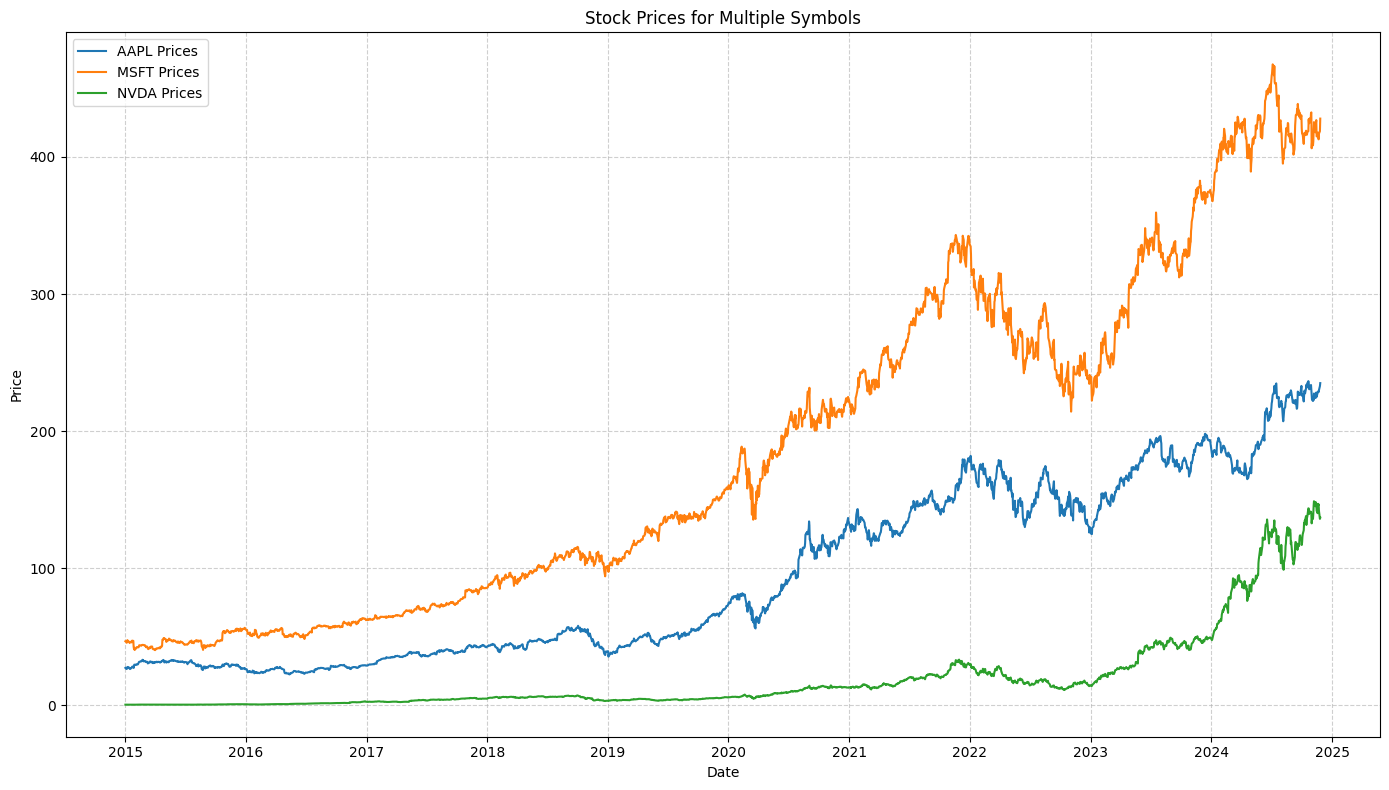

In [3]:
from src.visualization import plot_stock_prices
from src.utils import load_data

# Load and preprocess the data

# Preprocessing function: Normalizes the target data
def preprocess_data(df, target_column="Close", feature_columns=None, scaler=None):
    if target_column not in df.columns:
        raise KeyError(f"Column '{target_column}' not found in DataFrame.")

    # Select relevant features for LSTM
    feature_columns = feature_columns or [target_column]
    data = df[feature_columns].values

    # Handle missing values (forward and backward fill)
    data = pd.DataFrame(data).fillna(method='ffill').fillna(method='bfill').values

    # Initialize scaler if none provided
    if scaler is None:
        scaler = MinMaxScaler()

    # Normalize data to the range [0, 1]
    data_normalized = scaler.fit_transform(data)
    
    logging.info(f"Data normalization complete. Shape: {data_normalized.shape}")
    return data_normalized, scaler

# Load and preprocess
loaded_dfs = []

# Load each stock's data
for symbol in stock_symbols:
    data_file_path = os.path.join(data_dir, f"{symbol}_stock_data.parquet")
    try:
        df = load_data(data_file_path)
        loaded_dfs.append(df)
    except Exception as e:
        logging.error(f"Failed to load data for {symbol}: {e}")

# Plot the stock prices for all loaded symbols from the correct data directory
plot_stock_prices(stock_symbols, data_dir, target_column="Close")

## Step 4: Creating Sequences and Splitting Data

This section is crucial for preparing the data for LSTM training. We create sequences from the normalized data, which helps the LSTM learn patterns over time. We then split the data into training and validation sets.

In [4]:
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Sequence creation function
def create_sequences(data, sequence_length):
    if len(data) <= sequence_length:
        raise ValueError("Data length must be greater than the sequence length.")

    # Create sequences and corresponding labels
    num_sequences = len(data) - sequence_length
    sequences = np.array([data[i:i + sequence_length] for i in range(num_sequences)])
    labels = np.array([data[i + sequence_length] for i in range(num_sequences)])

    logging.info(f"Sequences created. Number of sequences: {len(sequences)}, Sequence length: {sequence_length}")
    return sequences, labels

# Splitting the data function
def split_data(sequences, labels, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(sequences, labels, test_size=test_size, random_state=42)
    logging.info(f"Data split complete. Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
    return X_train, X_val, y_train, y_val

# Preprocessing function to normalize and create sequences for each stock symbol
def preprocess_and_create_sequences(symbols, sequence_length, target_column="Close"):
    all_X_train = []
    all_X_val = []
    all_y_train = []
    all_y_val = []

    for symbol in symbols:
        target_column_name = f"{target_column}_{symbol}"
        # Load and preprocess data for each symbol
        data_file_path = os.path.join(data_dir, f"{symbol}_stock_data.parquet")
        try:
            df = load_data(data_file_path)

            if target_column_name not in df.columns:
                logging.error(f"Column '{target_column_name}' not found in DataFrame for {symbol}")
                continue

            # Normalize the target column
            data = df[target_column_name].values.reshape(-1, 1)
            scaler = MinMaxScaler()
            data_normalized = scaler.fit_transform(data)

            # Create sequences and labels for LSTM
            sequences, labels = create_sequences(data_normalized, sequence_length)

            # Split into training and validation datasets
            X_train, X_val, y_train, y_val = split_data(sequences, labels)

            # Append the data for each symbol
            all_X_train.append(X_train)
            all_X_val.append(X_val)
            all_y_train.append(y_train)
            all_y_val.append(y_val)

        except Exception as e:
            logging.error(f"Failed to load or preprocess data for {symbol}: {e}")

    # Concatenate the data from all symbols
    X_train_combined = np.concatenate(all_X_train, axis=0) if all_X_train else np.array([])
    X_val_combined = np.concatenate(all_X_val, axis=0) if all_X_val else np.array([])
    y_train_combined = np.concatenate(all_y_train, axis=0) if all_y_train else np.array([])
    y_val_combined = np.concatenate(all_y_val, axis=0) if all_y_val else np.array([])

    logging.info(f"Total training samples: {len(X_train_combined)}, Total validation samples: {len(X_val_combined)}")
    return X_train_combined, X_val_combined, y_train_combined, y_val_combined

sequence_length = 60
X_train, X_val, y_train, y_val = preprocess_and_create_sequences(stock_symbols, sequence_length, target_column="Close")

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")


2024-11-27 23:20:29,347 - INFO - Data loaded successfully from /media/nyx/Data2/Projects/time-series-stock-prediction/data/AAPL_stock_data.parquet
2024-11-27 23:20:29,350 - INFO - Sequences created. Number of sequences: 2433, Sequence length: 60
2024-11-27 23:20:29,352 - INFO - Data split complete. Training samples: 1946, Validation samples: 487
2024-11-27 23:20:29,353 - INFO - Data loaded successfully from /media/nyx/Data2/Projects/time-series-stock-prediction/data/MSFT_stock_data.parquet
2024-11-27 23:20:29,356 - INFO - Sequences created. Number of sequences: 2433, Sequence length: 60
2024-11-27 23:20:29,357 - INFO - Data split complete. Training samples: 1946, Validation samples: 487
2024-11-27 23:20:29,358 - INFO - Data loaded successfully from /media/nyx/Data2/Projects/time-series-stock-prediction/data/NVDA_stock_data.parquet
2024-11-27 23:20:29,361 - INFO - Sequences created. Number of sequences: 2433, Sequence length: 60
2024-11-27 23:20:29,362 - INFO - Data split complete. Trai

X_train shape: (5838, 60, 1), X_val shape: (1461, 60, 1)


## Step 5: Defining the LSTM Model

We define the architecture of the LSTM model, which includes LSTM layers followed by a fully connected layer to predict stock prices. This architecture is suitable for capturing sequential dependencies in the data.

In [5]:
# Define the LSTM model using PyTorch
class SequentialLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(SequentialLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the output from the last time step
        return out

# Instantiate the model
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
model = SequentialLSTM(input_size, hidden_size, num_layers, output_size)


## Step 6: Training the Model with Early Stopping

Here, we define a function to train the LSTM model using an early stopping mechanism to prevent overfitting. We also use gradient clipping to avoid exploding gradients. We save the best model based on validation loss.

In [6]:
# Early Stopping implementation
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Save checkpoint function
def save_checkpoint(model, filepath="best_model.pth"):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

# Training function with early stopping
def train_model_with_early_stopping(
    model, X_train, y_train, X_val, y_val, epochs=500, batch_size=32, patience=5, checkpoint_path="best_model.pth"
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Convert data to tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Define loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    early_stopping = EarlyStopping(patience=patience)

    # Training loop
    best_val_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            inputs = X_train_tensor[i:i + batch_size].to(device)
            targets = y_train_tensor[i:i + batch_size].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor.to(device))
            val_loss = criterion(val_outputs, y_val_tensor.to(device)).item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(model, checkpoint_path)

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

train_model_with_early_stopping(model, X_train, y_train, X_val, y_val, epochs=500, batch_size=32, patience=5)

Epoch 1/500, Train Loss: 3.1911, Val Loss: 0.0006
Model saved to best_model.pth
Epoch 2/500, Train Loss: 0.1395, Val Loss: 0.0004
Model saved to best_model.pth
Epoch 3/500, Train Loss: 0.1186, Val Loss: 0.0003
Model saved to best_model.pth
Epoch 4/500, Train Loss: 0.0984, Val Loss: 0.0003
Epoch 5/500, Train Loss: 0.0952, Val Loss: 0.0003
Model saved to best_model.pth
Epoch 6/500, Train Loss: 0.0909, Val Loss: 0.0003
Model saved to best_model.pth
Epoch 7/500, Train Loss: 0.0894, Val Loss: 0.0004
Epoch 8/500, Train Loss: 0.0793, Val Loss: 0.0003
Epoch 9/500, Train Loss: 0.0792, Val Loss: 0.0003
Model saved to best_model.pth
Epoch 10/500, Train Loss: 0.0755, Val Loss: 0.0004
Epoch 11/500, Train Loss: 0.0697, Val Loss: 0.0002
Model saved to best_model.pth
Epoch 12/500, Train Loss: 0.0638, Val Loss: 0.0003
Epoch 13/500, Train Loss: 0.0685, Val Loss: 0.0004
Epoch 14/500, Train Loss: 0.0684, Val Loss: 0.0004
Epoch 15/500, Train Loss: 0.0663, Val Loss: 0.0004
Epoch 16/500, Train Loss: 0.0652, 

## Step 7: Evaluating the Model

After training, we evaluate the model by comparing its predictions against actual stock prices from the validation set. The results are plotted to visualize the accuracy of the model.

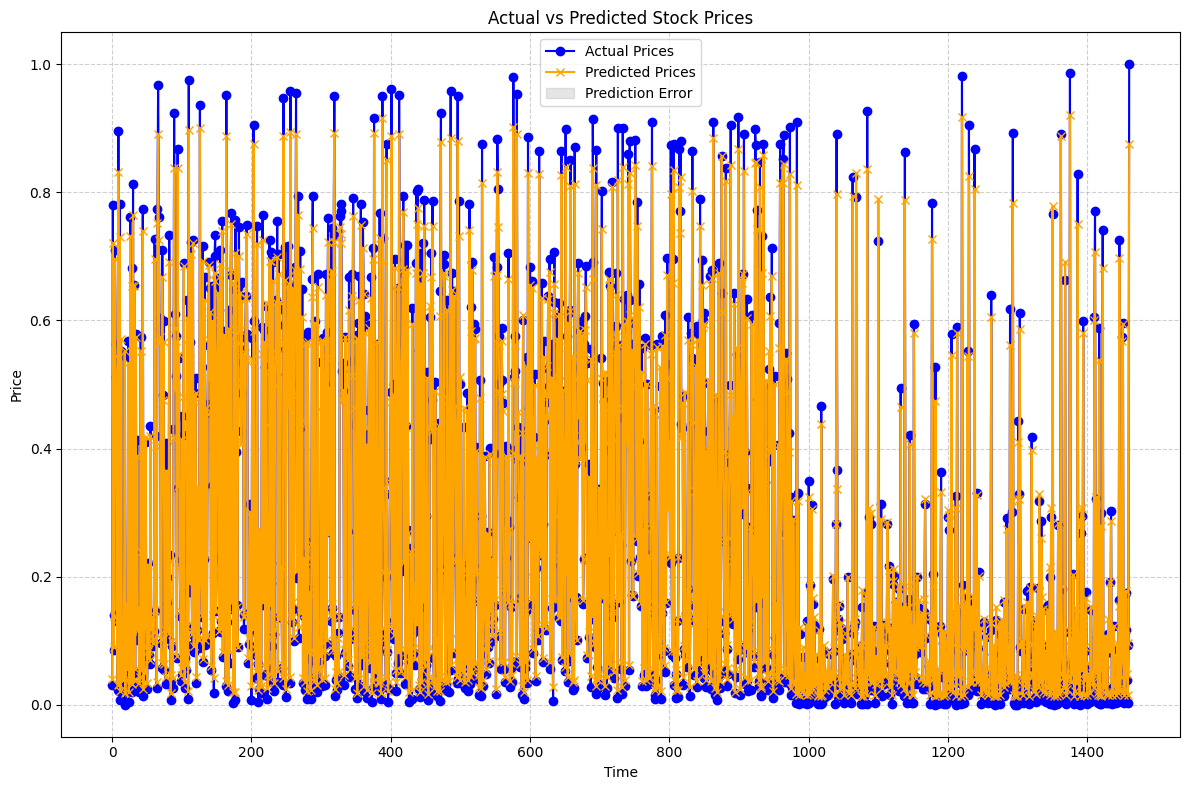

In [7]:
from src.visualization import plot_predictions

# Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Move input tensor to the same device as the model
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)

# Get predictions
with torch.no_grad():  # Disable gradient calculation for inference
    predicted = model(X_val_tensor).cpu().detach().numpy()  # Move predictions back to CPU for plotting

# Plot the actual vs predicted values
plot_predictions(y_val, predicted)
